In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 13.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=5d3de75ddb0ae4ab46f868dbcd9b45540ddc5e71838fd3a78ec17827d5f701e4
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from pyspark.sql.functions import approx_count_distinct,collect_list
from pyspark.sql.functions import collect_set,sum,avg,max,countDistinct,count
from pyspark.sql.functions import first, last, kurtosis, min, mean, skewness 
from pyspark.sql.functions import stddev, stddev_samp, stddev_pop, sumDistinct
from pyspark.sql.functions import variance,var_samp,  var_pop
from pyspark import SparkContext 
from pyspark.sql import SQLContext 
from pyspark.sql.types import StructType,StructField,StringType,IntegerType

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StringIndexerModel

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('taxi').getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

data = spark.read.csv('../input/taxi-data-processed/data_processed.csv', inferSchema=True, header=True)
zones = spark.read.csv('../input/taxi-data-processed/taxi_zones.csv', inferSchema=True, header=True)
data_original = spark.read.csv('/kaggle/input/taxt-2019/taxi-data.csv', inferSchema=True, header=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/03 03:05:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
data = data.withColumn('log_trip_distance',col = F.log(data.trip_distance))

In [5]:
data

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,travel_time_seconds,pickup_week,dropoff_week,log_trip_distance
1,2019-12-01 00:26:58,2019-12-01 00:41:45,1,4.2,1,N,142,116,2,14.5,3.0,0.5,0.0,0.0,0.3,18.3,2.5,887,1,1,1.4350845252893227
1,2019-12-01 00:12:03,2019-12-01 00:33:19,2,9.4,1,N,138,25,1,28.5,0.5,0.5,10.0,0.0,0.3,39.8,0.0,1276,1,1,2.2407096892759584
1,2019-12-01 00:05:27,2019-12-01 00:16:32,2,1.6,1,N,161,237,2,9.0,3.0,0.5,0.0,0.0,0.3,12.8,2.5,665,1,1,0.4700036292457356
1,2019-12-01 00:58:51,2019-12-01 01:08:37,2,1.0,1,N,161,230,2,6.5,3.0,0.5,0.0,0.0,0.3,10.3,2.5,586,1,1,0.0
1,2019-12-01 00:19:48,2019-12-01 00:24:18,1,0.9,1,N,148,4,1,5.5,3.0,0.5,1.85,0.0,0.3,11.15,2.5,270,1,1,-0.10536051565782628
1,2019-12-01 00:36:16,2019-12-01 00:53:42,3,5.5,1,N,79,226,1,18.0,3.0,0.5,4.35,0.0,0.3,26.15,2.5,1046,1,1,1.7047480922384253
2,2019-11-30 23:54:45,2019-12-01 00:09:57,1,2.12,1,N,234,230,2,12.0,0.5,0.5,0.0,0.0,0.3,15.8,2.5,912,7,1,0.7514160886839212
2,2019-12-01 00:39:43,2019-12-01 00:52:06,1,1.15,1,N,186,48,2,9.0,0.5,0.5,0.0,0.0,0.3,12.8,2.5,743,1,1,0.13976194237515863
2,2019-12-01 00:43:02,2019-12-01 01:11:18,1,13.07,1,N,41,51,2,38.5,0.5,0.5,0.0,0.0,0.3,39.8,0.0,1696,1,1,2.570319527636131
1,2019-12-01 00:57:16,2019-12-01 01:19:32,1,3.3,1,N,230,230,2,15.0,3.0,0.5,0.0,0.0,0.3,18.8,2.5,1336,1,1,1.1939224684724346


In [6]:
ratecodeid_count = data.groupby('RatecodeID').count().toPandas()

In [7]:
ratecodeid_count

,RatecodeID,count
0,1,5880308
1,3,14681
2,5,11398
3,4,4711
4,2,152820
5,6,8


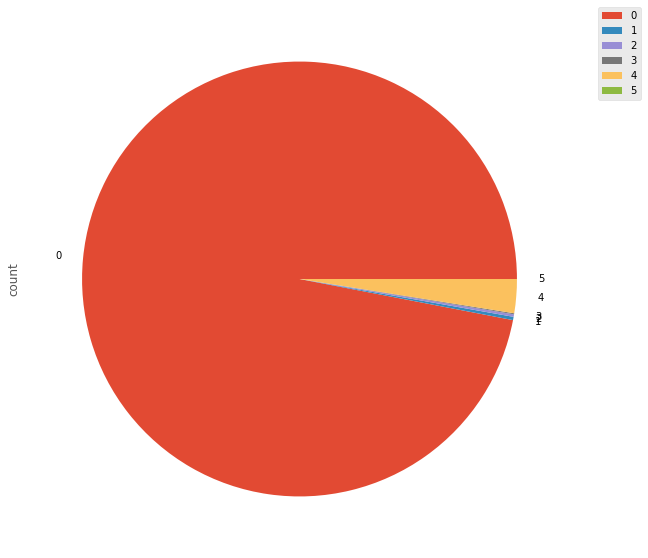

In [8]:
ratecodeid_count.plot(x='RatecodeID',y='count',kind='pie',figsize= (10, 10))
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.) 

# Find the Rule for RatecodeID=2

In [9]:
data.filter(data.RatecodeID==2).groupby('fare_amount').count()

fare_amount,count
0.0,90
38.5,1
40.5,1
16.5,3
22.0,1
27.0,1
13.0,2
52.0,152685
25.5,1
15.0,1


In [10]:
data.filter(data.RatecodeID==2).count()

152820

In [11]:
data.filter(data.RatecodeID==2).filter(data.fare_amount==52.0).count()

152685

In [12]:
data.filter(data.RatecodeID==2).filter(data.fare_amount==52.0).agg(F.mean('trip_distance'))

avg(trip_distance)
17.847490126731515


# Train, Test Split

In [13]:
assembler = VectorAssembler(inputCols=['trip_distance'],outputCol="features")
data_st_ml = assembler.transform(data)
data_st_ml = data_st_ml.select('features','fare_amount')

train, test = data_st_ml.randomSplit(weights = [0.70, 0.30], seed = 42)

# Linear Regression for ratecode ID =1 (Standard Price)

In [14]:
train_1 = train.filter(data.RatecodeID==1)
test_1 = test.filter(data.RatecodeID==1)

In [15]:
train_1

features,fare_amount
[0.01],0.0
[0.01],0.0
[0.02],0.0
[0.05],0.0
[0.05],0.0
[0.07],0.0
[0.1],0.0
[0.1],0.0
[0.12],0.0
[0.13],0.0


In [16]:
lr = LinearRegression(regParam=0.0, labelCol = 'fare_amount')

lr_model_1 = lr.fit(train_1)


22/12/03 03:07:31 WARN Instrumentation: [a4447798] regParam is zero, which might cause numerical instability and overfitting.


In [17]:
print('RatecodeID=1,coefficients:',lr_model_1.coefficients)
print('RatecodeID=1, intercept:', lr_model_1.intercept)

RatecodeID=1,coefficients: [2.816856531205697]
RatecodeID=1, intercept: 4.778404863461258


model :  $y = 2.82 + 4.78$

In [18]:
pred_1 = lr_model_1.transform(test_1)

In [19]:
lr_model_1_sum = lr_model_1.evaluate(test_1)

In [20]:
print("r2:",lr_model_1_sum.r2)
print("MAE:",lr_model_1_sum.meanAbsoluteError)
print("MSE:",lr_model_1_sum.meanSquaredError)


r2: 0.8964739660407168
MAE: 1.9239315594342634
MSE: 7.273426052432405


In [21]:
# # evaluate of model 1
# pred_1 = lr_model_1.transform(test_1)

# cnt = test_1.count()
# ae_variance = pred_1.withColumn('abs_error_variance', col = (F.abs(pred_1.prediction - pred_1.fare_amount) - mae)**2).groupby().sum('abs_error_variance').toPandas().iat[0, 0] / cnt

# print('RatecodeID=1, (model: y = 2.51 + 5.54) Variance of abs error = %g' % ae_variance)


* For ratecodeID = 1, **MAE = 1.9, variance of abs error = 3.57, r2=0.896**

#  GBT model for ratecode ID =3,4,5,6

In [22]:
data_not_12 = data.filter(data.RatecodeID != 1).filter(data.RatecodeID != 2)

In [23]:
#binary trans
def trans_store_and_fwd_flag(x):
    if x == 'Y':
        return 1
    else:
        return 0

fun = F.udf(trans_store_and_fwd_flag,IntegerType())
data_not_12 = data_not_12.withColumn('store_and_fwd_flag_binary', col = fun(data_not_12.store_and_fwd_flag))



In [24]:
# add day of year
data_not_12 = data_not_12.withColumn('dayofyear',col = F.dayofyear('tpep_dropoff_datetime'))

# add hour of day
data_not_12 = data_not_12.withColumn('pickup_hour',col = F.hour(data_not_12.tpep_pickup_datetime))
data_not_12 = data_not_12.withColumn('dropoff_hour',col = F.hour(data_not_12.tpep_dropoff_datetime))

In [25]:
data_not_12_zones_temp = data_not_12.join(zones,data_not_12.PULocationID == zones.LocationID).drop('LocationID')

data_not_12_zones_temp = data_not_12_zones_temp.withColumnRenamed('Borough', 'PUBorough')
data_not_12_zones_temp = data_not_12_zones_temp.withColumnRenamed('Zone', 'PUZone')
data_not_12_zones_temp = data_not_12_zones_temp.withColumnRenamed('service_zone', 'PUservice_zone')

data_not_12_zones = data_not_12_zones_temp.join(zones,data_not_12_zones_temp.DOLocationID==zones.LocationID).drop('LocationID')

data_not_12_zones = data_not_12_zones.withColumnRenamed('Borough', 'DOBorough')
data_not_12_zones = data_not_12_zones.withColumnRenamed('Zone', 'DOZone')
data_not_12 = data_not_12_zones.withColumnRenamed('service_zone', 'DOservice_zone')

In [26]:
labeling_col = ['PUBorough',
 'PUservice_zone',
 'DOBorough',
 'DOservice_zone']

labeling_col_out = ['PUBorough_',
 'PUservice_zone_',
 'DOBorough_',
 'DOservice_zone_']

label_encoder = StringIndexer(inputCols=labeling_col, outputCols=labeling_col_out).setHandleInvalid("keep")

label_model=label_encoder.fit(data_not_12)
data_not_12_ml = label_model.transform(data_not_12)

In [27]:
one_hot_col = ['payment_type', 'RatecodeID']
one_hot_col_out = ['payment_type_', 'RatecodeID_']
onehot_encoder = OneHotEncoder(inputCols=one_hot_col, outputCols=one_hot_col_out)

label_model=onehot_encoder.fit(data_not_12_ml)
data_not_12_ml = label_model.transform(data_not_12_ml)
#使用OneHotEncoder将分类变量转换为二进制稀疏向量

In [28]:
data_not_12_ml

22/12/03 03:09:00 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,travel_time_seconds,pickup_week,dropoff_week,log_trip_distance,store_and_fwd_flag_binary,dayofyear,pickup_hour,dropoff_hour,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone,PUBorough_,PUservice_zone_,DOBorough_,DOservice_zone_,payment_type_,RatecodeID_
1,2019-12-01 00:43:27,2019-12-01 01:23:30,1,23.5,4,N,68,265,1,85.5,3.0,0.5,17.85,0.0,0.3,107.15,2.5,2403,1,1,3.157000421150113,0,335,0,1,Manhattan,East Chelsea,Yellow Zone,Unknown,NA,N/A,0.0,0.0,1.0,1.0,"(4,[1],[1.0])","(6,[4],[1.0])"
2,2019-12-01 00:58:28,2019-12-01 01:36:13,2,23.88,5,N,138,265,2,78.5,0.0,0.0,0.0,16.62,0.3,95.42,0.0,2265,1,1,3.1730412885244013,0,335,0,1,Queens,LaGuardia Airport,Airports,Unknown,NA,N/A,1.0,1.0,1.0,1.0,"(4,[2],[1.0])","(6,[5],[1.0])"
2,2019-12-01 00:16:50,2019-12-01 00:44:07,5,16.97,3,N,100,1,1,63.5,0.5,0.0,5.0,10.5,0.3,79.8,0.0,1637,1,1,2.831447079246135,0,335,0,0,Manhattan,Garment District,Yellow Zone,EWR,Newark Airport,EWR,0.0,0.0,0.0,0.0,"(4,[1],[1.0])","(6,[3],[1.0])"
2,2019-12-01 00:09:19,2019-12-01 00:43:56,3,23.93,5,N,239,265,1,60.0,0.0,0.0,13.78,6.12,0.3,82.7,2.5,2077,1,1,3.175132901920282,0,335,0,0,Manhattan,Upper West Side S...,Yellow Zone,Unknown,NA,N/A,0.0,0.0,1.0,1.0,"(4,[1],[1.0])","(6,[5],[1.0])"
2,2019-12-01 00:44:53,2019-12-01 01:14:26,2,18.13,4,N,161,265,2,57.0,0.5,0.5,0.0,6.12,0.3,66.92,2.5,1773,1,1,2.8975680247667595,0,335,0,1,Manhattan,Midtown Center,Yellow Zone,Unknown,NA,N/A,0.0,0.0,1.0,1.0,"(4,[2],[1.0])","(6,[4],[1.0])"
2,2019-12-01 00:56:37,2019-12-01 01:16:38,4,14.85,4,N,138,265,2,44.0,0.5,0.5,0.0,6.12,0.3,51.42,0.0,1201,1,1,2.6979998652487085,0,335,0,1,Queens,LaGuardia Airport,Airports,Unknown,NA,N/A,1.0,1.0,1.0,1.0,"(4,[2],[1.0])","(6,[4],[1.0])"
2,2019-12-01 00:05:20,2019-12-01 00:21:58,1,5.27,5,N,249,265,1,45.0,0.0,0.5,11.76,10.5,0.3,70.56,2.5,998,1,1,1.6620303625532709,0,335,0,0,Manhattan,West Village,Yellow Zone,Unknown,NA,N/A,0.0,0.0,1.0,1.0,"(4,[1],[1.0])","(6,[5],[1.0])"
2,2019-12-01 00:59:02,2019-12-01 01:13:51,2,5.25,5,N,164,265,1,40.0,0.0,0.5,10.76,10.5,0.3,64.56,2.5,889,1,1,1.6582280766035324,0,335,0,1,Manhattan,Midtown South,Yellow Zone,Unknown,NA,N/A,0.0,0.0,1.0,1.0,"(4,[1],[1.0])","(6,[5],[1.0])"
2,2019-12-01 00:28:36,2019-12-01 01:18:10,1,37.7,5,N,132,265,1,100.0,0.0,0.0,26.71,33.24,0.3,160.25,0.0,2974,1,1,3.629660094453965,0,335,0,1,Queens,JFK Airport,Airports,Unknown,NA,N/A,1.0,1.0,1.0,1.0,"(4,[1],[1.0])","(6,[5],[1.0])"
2,2019-12-01 00:24:42,2019-12-01 00:44:05,1,8.53,5,N,90,265,1,60.0,0.0,0.0,14.8,11.2,0.3,88.8,2.5,1163,1,1,2.1435893615035875,0,335,0,0,Manhattan,Flatiron,Yellow Zone,Unknown,NA,N/A,0.0,0.0,1.0,1.0,"(4,[1],[1.0])","(6,[5],[1.0])"


In [29]:
feature_cols = [
 'passenger_count',
 'trip_distance',
 'RatecodeID_',
 'store_and_fwd_flag_binary',
 'payment_type_',
 'travel_time_seconds',
 'pickup_week',
 'dropoff_week',
 'dayofyear',
 'pickup_hour',
 'dropoff_hour',
 'PUBorough_',
 'PUservice_zone_',
 'DOBorough_',
 'DOservice_zone_',]

In [30]:
assembler = VectorAssembler(inputCols=feature_cols,outputCol="features")
data_not_12_ml_final = assembler.transform(data_not_12_ml).select('features','fare_amount')

train_3, test_3 = data_not_12_ml_final.randomSplit(weights = [0.70, 0.30], seed = 42)

GBT model training and test

In [31]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import GBTRegressor

In [32]:
# gbt fit
gbt_f = GBTRegressor(featuresCol="features", labelCol='fare_amount', maxDepth=5, maxIter=5, seed=42)
gbt_f_Model = gbt_f.fit(train_3)

In [33]:
# gbt prediction
predictions_fare = gbt_f_Model.transform(test_3)
predictions_fare.select("prediction", "fare_amount", "features").show(20)

+------------------+-----------+--------------------+
|        prediction|fare_amount|            features|
+------------------+-----------+--------------------+
| 44.72549104610867|       47.0|(23,[0,1,5,8,10,1...|
|  59.3177925147807|       56.0|(23,[0,1,5,8,11,1...|
| 76.61806790379516|       75.0|(23,[0,1,5,8,11,1...|
| 80.68749951621511|       76.0|(23,[0,1,5,8,11,1...|
|61.498225350886585|       64.5|(23,[0,1,5,8,11,1...|
|31.445865239000955|       38.0|(23,[0,1,5,8,11,1...|
| 75.00473794082492|       75.0|(23,[0,1,5,8,12,1...|
|61.498225350886585|       63.5|(23,[0,1,5,10,13,...|
| 56.01301639269387|       53.0|(23,[0,1,5,10,13,...|
|  59.3177925147807|       51.5|(23,[0,1,5,10,13,...|
|  59.3177925147807|       53.5|(23,[0,1,5,10,13,...|
|  59.3177925147807|       54.0|(23,[0,1,5,10,13,...|
|  59.3177925147807|       52.0|(23,[0,1,5,10,13,...|
|  59.3177925147807|       54.0|(23,[0,1,5,10,13,...|
|  59.3177925147807|       57.0|(23,[0,1,5,10,13,...|
|  59.3177925147807|       5

解释性

In [34]:
# see important features
gbt_f_Model.featureImportances

SparseVector(23, {0: 0.0005, 1: 0.659, 5: 0.0184, 7: 0.0479, 8: 0.001, 10: 0.0186, 11: 0.015, 12: 0.0318, 13: 0.0672, 14: 0.0026, 16: 0.0049, 17: 0.0137, 18: 0.0259, 19: 0.0065, 20: 0.0111, 21: 0.0742, 22: 0.0018})

In [35]:
gbt_model_show_string = gbt_f_Model.toDebugString
print(gbt_model_show_string)

GBTRegressionModel: uid=GBTRegressor_05f230eb651c, numTrees=5, numFeatures=23
  Tree 0 (weight 1.0):
    If (feature 1 <= 26.619999999999997)
     If (feature 1 <= 10.295)
      If (feature 1 <= 1.81)
       If (feature 5 in {0.0})
        If (feature 10 in {0.0})
         Predict: 1.9772072072072069
        Else (feature 10 not in {0.0})
         Predict: 11.082922077922076
       Else (feature 5 not in {0.0})
        If (feature 13 <= 1027.5)
         Predict: 23.43103448275862
        Else (feature 13 > 1027.5)
         Predict: 11.5
      Else (feature 1 > 1.81)
       If (feature 7 in {0.0})
        If (feature 13 <= 1444.5)
         Predict: 30.54436090225564
        Else (feature 13 > 1444.5)
         Predict: 42.54010695187166
       Else (feature 7 not in {0.0})
        If (feature 12 in {1.0})
         Predict: 12.657499999999999
        Else (feature 12 not in {1.0})
         Predict: 50.443726899383975
     Else (feature 1 > 10.295)
      If (feature 1 <= 20.735)
       If 

evaluation

In [36]:
# evaluate
evaluator_mse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mae")
mse = evaluator_mse.evaluate(predictions_fare)
mae = evaluator_mae.evaluate(predictions_fare)

print("Mean Squared Error (MSE) on test data = %g" % mse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

cnt = test.count()
# predictions_fare_ = predictions_fare.withColumn('abs_error_variance', col = (F.abs(predictions_fare.prediction - predictions_fare.fare_amount) - mae)**2)
ae_variance_fare = predictions_fare.withColumn('abs_error_variance', col = (F.abs(predictions_fare.prediction - predictions_fare.fare_amount) - mae)**2).groupby().sum('abs_error_variance').toPandas().iat[0, 0] / cnt

print('Variance of abs error = %g' % ae_variance_fare)

Mean Squared Error (MSE) on test data = 348.498
Mean Absolute Error (MAE) on test data = 9.47386


Variance of abs error = 1.28506


# Whole Model for prediction

In [37]:
from pyspark.sql.functions import monotonically_increasing_id as mi

def trans_store_and_fwd_flag(x):
    if x == 'Y':
        return 1
    else:
        return 0
    
class fare_calculation_model():
    def __init__(self):
        pass
    
    #input the data needed to be test by calling this function
    def preprocess(self,row_data):
        id=mi()
        row_data = row_data.withColumn("match_id", id)
        self.label = row_data.select('match_id','fare_amount') # dataframe with 2 columns : 'match_id','fare_amount'
        self.r1 = row_data.filter(row_data.RatecodeID==1)
        self.r2 = row_data.filter(row_data.RatecodeID==2)
        
        self.r3 = row_data.filter(row_data.RatecodeID!=1).filter(row_data.RatecodeID!=2)
        self.FE() #创建self.r3_ml
        
    def FE(self):

        fun = F.udf(trans_store_and_fwd_flag,IntegerType())
        self.r3 = self.r3.withColumn('store_and_fwd_flag_binary', col = fun(self.r3.store_and_fwd_flag))

        # add day of year
        self.r3 = self.r3.withColumn('dayofyear',col = F.dayofyear('tpep_dropoff_datetime'))

        # add hour of day
        self.r3 = self.r3.withColumn('pickup_hour',col = F.hour(self.r3.tpep_pickup_datetime))
        self.r3 = self.r3.withColumn('dropoff_hour',col = F.hour(self.r3.tpep_dropoff_datetime))

        data_not_12_zones_temp = self.r3.join(zones,self.r3.PULocationID == zones.LocationID).drop('LocationID')

        data_not_12_zones_temp = data_not_12_zones_temp.withColumnRenamed('Borough', 'PUBorough')
        data_not_12_zones_temp = data_not_12_zones_temp.withColumnRenamed('Zone', 'PUZone')
        data_not_12_zones_temp = data_not_12_zones_temp.withColumnRenamed('service_zone', 'PUservice_zone')

        data_not_12_zones = data_not_12_zones_temp.join(zones,data_not_12_zones_temp.DOLocationID==zones.LocationID).drop('LocationID')

        data_not_12_zones = data_not_12_zones.withColumnRenamed('Borough', 'DOBorough')
        data_not_12_zones = data_not_12_zones.withColumnRenamed('Zone', 'DOZone')
        data_not_12 = data_not_12_zones.withColumnRenamed('service_zone', 'DOservice_zone')

        labeling_col = ['PUBorough',
         'PUservice_zone',
         'DOBorough',
         'DOservice_zone']

        labeling_col_out = ['PUBorough_',
         'PUservice_zone_',
         'DOBorough_',
         'DOservice_zone_']

        label_encoder = StringIndexer(inputCols=labeling_col, outputCols=labeling_col_out).setHandleInvalid("keep")

        label_model=label_encoder.fit(data_not_12)
        data_not_12_ml = label_model.transform(data_not_12)

        one_hot_col = ['payment_type', 'RatecodeID']
        one_hot_col_out = ['payment_type_', 'RatecodeID_']
        onehot_encoder = OneHotEncoder(inputCols=one_hot_col, outputCols=one_hot_col_out)

        label_model=onehot_encoder.fit(data_not_12_ml)
        data_not_12_ml = label_model.transform(data_not_12_ml)
        #使用OneHotEncoder将分类变量转换为二进制稀疏向量

        feature_cols = [
         'passenger_count',
         'trip_distance',
         'RatecodeID_',
         'store_and_fwd_flag_binary',
         'payment_type_',
         'travel_time_seconds',
         'pickup_week',
         'dropoff_week',
         'dayofyear',
         'pickup_hour',
         'dropoff_hour',
         'PUBorough_',
         'PUservice_zone_',
         'DOBorough_',
         'DOservice_zone_',]


        assembler = VectorAssembler(inputCols=feature_cols,outputCol="features")
        self.r3_ml  = assembler.transform(data_not_12_ml).select('match_id','features','fare_amount')
        
    def predict(self):
        p1 = self.r1.selectExpr('match_id','trip_distance * 2.817 + 4.7784 as prediction')
        p2 = self.r2.selectExpr('match_id','52 as prediction')
        p3 = gbt_f_Model.transform(self.r3_ml).selectExpr('match_id','prediction')
        
        temp = p1.union(p2).union(p3) # 2列： match_id, prediction 
        self.prediction = temp.join(self.label, self.label.match_id == temp.match_id,'inner')
        self.prediction.show(20) #3列，match_id, prediction, fare_amount
        
        self.evaluate()
        
    def evaluate(self):
        
        # evaluate
        evaluator_mse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mse")
        evaluator_mae = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mae")
        mse = evaluator_mse.evaluate(self.prediction)
        mae = evaluator_mae.evaluate(self.prediction)

        print("Mean Squared Error (MSE) on test data = %g" % mse)
        print("Mean Absolute Error (MAE) on test data = %g" % mae)

        cnt = self.prediction.count()
        ae_variance_fare = self.prediction.withColumn('abs_error_variance', col = (F.abs(self.prediction.prediction - self.prediction.fare_amount) - mae)**2).groupby().sum('abs_error_variance').toPandas().iat[0, 0] / cnt

        print('Variance of abs error = %g' % ae_variance_fare)
    
        
        
        

In [38]:
data_not_12.selectExpr('0')


0
0
0
0
0
0
0
0
0
0
0


In [39]:
fcm = fare_calculation_model()
fcm.preprocess(data)
fcm.predict()

+--------+------------------+--------+-----------+
|match_id|        prediction|match_id|fare_amount|
+--------+------------------+--------+-----------+
|       0|           16.6098|       0|       14.5|
|       6|10.750440000000001|       6|       12.0|
|       7|           8.01795|       7|        9.0|
|       9|           14.0745|       9|       15.0|
|      19|14.919600000000003|      19|       12.5|
|      22|11.511030000000002|      22|       10.5|
|      25|            6.4686|      25|        5.0|
|      26|           18.5817|      26|       19.5|
|      29|            9.5673|      29|        7.5|
|      31|23.370600000000003|      31|       20.5|
|      32|           13.7928|      32|       13.0|
|      34|12.243450000000001|      34|        9.5|
|      39|           19.4268|      39|       17.5|
|      43|          12.41247|      43|       12.5|
|      50|14.187180000000001|      50|       12.0|
|      54| 9.003900000000002|      54|       10.0|
|      57|10.412400000000002|  

Mean Squared Error (MSE) on test data = 8.72826
Mean Absolute Error (MAE) on test data = 1.91109


Variance of abs error = 5.076


## only consider RatecodeID == 1,2

In [40]:
from pyspark.sql.functions import monotonically_increasing_id as mi
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import GBTRegressor
def trans_store_and_fwd_flag(x):
    if x == 'Y':
        return 1
    else:
        return 0
    
class fare_calculation_model1():
    def __init__(self):
        pass
    
    #input the data needed to be test by calling this function
    def preprocess(self,row_data):
        id=mi()
        row_data = row_data.withColumn("match_id", id)
        self.label = row_data.select('match_id','fare_amount') # dataframe with 2 columns : 'match_id','fare_amount'
        self.r1 = row_data.filter(row_data.RatecodeID==1)
        self.r2 = row_data.filter(row_data.RatecodeID==2)
        
#         self.r3 = row_data.filter(row_data.RatecodeID!=1).filter(row_data.RatecodeID!=2)
#         self.FE() #创建self.r3_ml
        
    def FE(self):

        fun = F.udf(trans_store_and_fwd_flag,IntegerType())
        self.r3 = self.r3.withColumn('store_and_fwd_flag_binary', col = fun(self.r3.store_and_fwd_flag))

        # add day of year
        self.r3 = self.r3.withColumn('dayofyear',col = F.dayofyear('tpep_dropoff_datetime'))

        # add hour of day
        self.r3 = self.r3.withColumn('pickup_hour',col = F.hour(self.r3.tpep_pickup_datetime))
        self.r3 = self.r3.withColumn('dropoff_hour',col = F.hour(self.r3.tpep_dropoff_datetime))

        data_not_12_zones_temp = self.r3.join(zones,self.r3.PULocationID == zones.LocationID).drop('LocationID')

        data_not_12_zones_temp = data_not_12_zones_temp.withColumnRenamed('Borough', 'PUBorough')
        data_not_12_zones_temp = data_not_12_zones_temp.withColumnRenamed('Zone', 'PUZone')
        data_not_12_zones_temp = data_not_12_zones_temp.withColumnRenamed('service_zone', 'PUservice_zone')

        data_not_12_zones = data_not_12_zones_temp.join(zones,data_not_12_zones_temp.DOLocationID==zones.LocationID).drop('LocationID')

        data_not_12_zones = data_not_12_zones.withColumnRenamed('Borough', 'DOBorough')
        data_not_12_zones = data_not_12_zones.withColumnRenamed('Zone', 'DOZone')
        data_not_12 = data_not_12_zones.withColumnRenamed('service_zone', 'DOservice_zone')

        labeling_col = ['PUBorough',
         'PUservice_zone',
         'DOBorough',
         'DOservice_zone']

        labeling_col_out = ['PUBorough_',
         'PUservice_zone_',
         'DOBorough_',
         'DOservice_zone_']

        label_encoder = StringIndexer(inputCols=labeling_col, outputCols=labeling_col_out).setHandleInvalid("keep")

        label_model=label_encoder.fit(data_not_12)
        data_not_12_ml = label_model.transform(data_not_12)

        one_hot_col = ['payment_type', 'RatecodeID']
        one_hot_col_out = ['payment_type_', 'RatecodeID_']
        onehot_encoder = OneHotEncoder(inputCols=one_hot_col, outputCols=one_hot_col_out)

        label_model=onehot_encoder.fit(data_not_12_ml)
        data_not_12_ml = label_model.transform(data_not_12_ml)
        #使用OneHotEncoder将分类变量转换为二进制稀疏向量

        feature_cols = [
         'passenger_count',
         'trip_distance',
         'RatecodeID_',
         'store_and_fwd_flag_binary',
         'payment_type_',
         'travel_time_seconds',
         'pickup_week',
         'dropoff_week',
         'dayofyear',
         'pickup_hour',
         'dropoff_hour',
         'PUBorough_',
         'PUservice_zone_',
         'DOBorough_',
         'DOservice_zone_',]


        assembler = VectorAssembler(inputCols=feature_cols,outputCol="features")
        self.r3_ml  = assembler.transform(data_not_12_ml).select('match_id','features','fare_amount')
        
    def predict(self):
        p1 = self.r1.selectExpr('match_id','trip_distance * 2.817 + 4.7784 as prediction')
        p2 = self.r2.selectExpr('match_id','52 as prediction')
#         p3 = gbt_f_Model.transform(self.r3_ml).selectExpr('match_id','prediction')
        
        temp = p1.union(p2) # 2列： match_id, prediction 
        self.prediction = temp.join(self.label, self.label.match_id == temp.match_id,'inner')
        self.prediction.show(20) #3列，match_id, prediction, fare_amount
        
        self.evaluate()
        
    def evaluate(self):
        
        # evaluate
        evaluator_mse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mse")
        evaluator_mae = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mae")
        mse = evaluator_mse.evaluate(self.prediction)
        mae = evaluator_mae.evaluate(self.prediction)

        print("Mean Squared Error (MSE) on test data = %g" % mse)
        print("Mean Absolute Error (MAE) on test data = %g" % mae)

        cnt = self.prediction.count()
        ae_variance_fare = self.prediction.withColumn('abs_error_variance', col = (F.abs(self.prediction.prediction - self.prediction.fare_amount) - mae)**2).groupby().sum('abs_error_variance').toPandas().iat[0, 0] / cnt

        print('Variance of abs error = %g' % ae_variance_fare)
    
        
        
        

In [41]:
train_, test_ = data.randomSplit(weights = [0.70, 0.30], seed = 42)

In [ ]:
fcm = fare_calculation_model1()
fcm.preprocess(test_)
fcm.predict()

+--------+------------------+--------+-----------+
|match_id|        prediction|match_id|fare_amount|
+--------+------------------+--------+-----------+
|       0|              52.0|       0|       52.0|
|       6|32.385000000000005|       6|       29.0|
|       7|11.539200000000001|       7|       12.0|
|      19|           17.1732|      19|       17.0|
|      22|             9.849|      22|        9.5|
|      25|           19.9902|      25|       21.5|
|      26|              52.0|      26|       52.0|
|      29|           11.2575|      29|       10.0|
|      31|11.539200000000001|      31|       11.5|
|      32|            8.7222|      32|        6.5|
|      34| 8.158800000000001|      34|       10.5|
|      39|            6.7503|      39|        6.0|
|      43|              52.0|      43|       52.0|
|      50|22.243800000000004|      50|       24.5|
|      54|             7.032|      54|        5.5|
|      57| 7.595400000000001|      57|        6.5|
|      58| 8.158800000000001|  

Mean Squared Error (MSE) on test data = 7.08783
Mean Absolute Error (MAE) on test data = 1.87339


## Robustness Test

In [43]:
data_original = data_original.withColumn("travel_time_seconds", col = data_original['tpep_dropoff_datetime'].cast('long')-data_original['tpep_pickup_datetime'].cast('long'))
data_original = data_original.withColumn('pickup_week',col = F.dayofweek('tpep_pickup_datetime'))
data_original = data_original.withColumn('dropoff_week',col = F.dayofweek('tpep_dropoff_datetime'))

In [49]:
train_1, test_1 = data_original.randomSplit(weights = [0.70, 0.30], seed = 42)

In [52]:
fcm = fare_calculation_model1()
fcm.preprocess(data_original)
fcm.predict()

+--------+------------------+--------+-----------+
|match_id|        prediction|match_id|fare_amount|
+--------+------------------+--------+-----------+
|       0|           16.6098|       0|       14.5|
|       6|            9.5673|       6|       10.0|
|       7|6.1869000000000005|       7|        4.0|
|      19|           36.6105|      19|       33.5|
|      22|13.539270000000002|      22|       12.0|
|      25| 8.158800000000001|      25|        5.5|
|      26|14.919600000000003|      26|       12.5|
|      29|11.511030000000002|      29|       10.5|
|      31|           18.0183|      31|       15.5|
|      32|            6.4686|      32|        5.0|
|      34|          15.34215|      34|       14.5|
|      39|           13.7928|      39|       13.0|
|      43|12.384300000000001|      43|       11.5|
|      50|          12.41247|      50|       12.5|
|      54|           8.04612|      54|        7.0|
|      57|           25.3425|      57|       20.5|
|      58|14.187180000000001|  

Mean Squared Error (MSE) on test data = 23438.2
Mean Absolute Error (MAE) on test data = 2.0695


Variance of abs error = 23433.9
